Firstly the images must be loaded from the dataset directory, and then pre-processed so they can be fed into the SVM classifier.
I will pre-process each image and load it in with it's corresponding ClassId.
The labels for the dataset are loaded in as a dataframe from the csv file.

I have chosen to resize each image to 32x32 and turn it into greyscale to process less features, this reduces memory usage and speeds up training (and still leaves enough features for the model to effectivley distinguish classes). The images are flattened aswell as the SVM model expects a 2D array as input.

In [3]:
import os
import cv2
import numpy as np
import pandas as pd

data_path = 'data/traffic_Data/DATA'
test_path = 'data/traffic_Data/TEST'
labels_path = 'data/labels.csv'

images = []
class_ids = []
labels = pd.read_csv(labels_path)

for class_id in range(58):
    directory = os.path.join(data_path, str(class_id))
    if os.path.exists(directory):
        for img_file in os.listdir(directory):
            img_path = os.path.join(directory, img_file)
            image = cv2.imread(img_path)
            image = cv2.resize(image, (32, 32)) # Resize
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # Greyscale
            image = image.flatten() # Flatten
            images.append(image)
            class_ids.append(class_id)
            
# Define X (input data) and y (target data) as numpy arrays
X = np.array(images)
y = np.array(class_ids)

Next, before splitting the data I will carry out 2 more steps.
Firstly, we standardize (scale) the features so the transformation is applied uniformly across the whole dataset. If this was done after splitting, then there is a risk of different scaling parameters (e.g mean and variance) across the training and testing sets.
Secondly, we apply Principle Component Analysis (PCA) to extract the most meaningful features by keeping the principle components that capture the most variance. This makes the SVM model faster to train and more computationally efficient without a significant loss in accuracy.

I have used the method outlined in the PCA tutorial to plot cumulative variance against the number of components, to visualise and determine the minimum amount of principle components to use.
It seems like 250 components capture around 95% of the variance, which is sufficient.

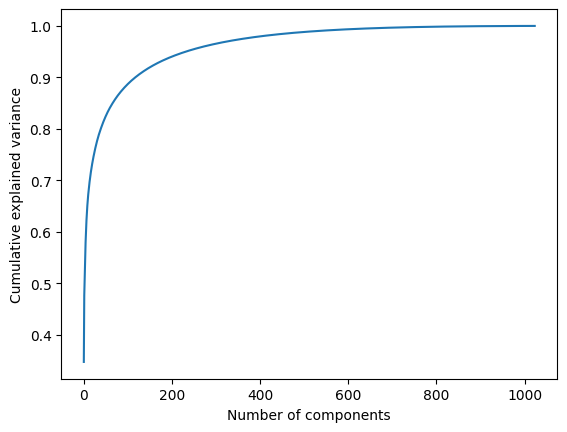

In [7]:
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca_test = PCA().fit(X_scaled)
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

pca = PCA(n_components=250)
X_pca = pca.fit_transform(X_scaled)
